In [1]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf            # statistics and econometrics
from scipy.optimize import minimize              # for function minimization
from dateutil.relativedelta import relativedelta  # working with dates with style
import seaborn as sns                            # more plots
import matplotlib.pyplot as plt                  # plots
import pandas as pd                              # tables and data manipulations
import numpy as np                               # vectors and matrices
import warnings                 
from scipy import stats      
from sklearn.preprocessing import StandardScaler           # `do not disturbe` mode
warnings.filterwarnings('ignore')


In [29]:
pd.options.display.float_format = '{:,.10f}'.format
db = pd.read_csv('Bias_correction_ucl.csv').dropna()
db.Date = pd.to_datetime(db.Date)
db['Year'] = db.Date.dt.year
db['month'] = db.Date.dt.month

db['LDAPS_LH_sqrt'] = db.LDAPS_LH**2
# Daily Cloud cover
db_aux = db.groupby(['station', 'month']).agg({"Present_Tmax": [
    "mean", "var"], "LDAPS_Tmax_lapse": ["mean", "var"]}).reset_index()
db.Present_Tmax = db.Present_Tmax ** 2
db = db.merge(db_aux, on=['station', 'month'], how='left')
db = db.drop(['month'], axis=1)

db = db.set_index(['station', 'Date', 'Year'])
db = db[(np.abs(stats.zscore(db)) < 6).all(axis=1)]
#db['Test_feature'] =
target = db[['Next_Tmax', 'Next_Tmin']]
features = db.drop(['Next_Tmax', 'Next_Tmin'], axis=1)


In [27]:
target.loc[pd.IndexSlice[[
    1], :, [2017]], :]['Next_Tmax'].var(), target.loc[pd.IndexSlice[[
        1], :, [2017]], :]['Next_Tmin'].var()


(8.645551912568305, 5.451857923497268)

<AxesSubplot:xlabel='station,Date,Year'>

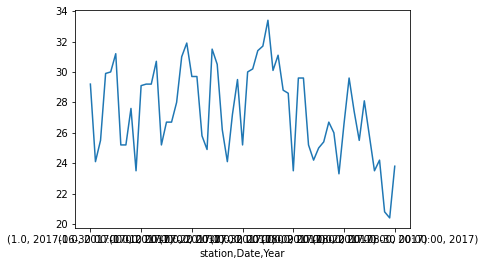

In [7]:
target.loc[pd.IndexSlice[[
    1], :, [2017]], :]['Next_Tmax'].plot()


In [9]:

x_scaler = StandardScaler()
norm_features = pd.DataFrame(x_scaler.fit_transform(
    features.values), columns=features.columns, index=features.index)
y_scaler_Tmax = StandardScaler()
y_scaler_fit_Tmax = y_scaler_Tmax.fit(
    np.array(target['Next_Tmax']).reshape(-1, 1))
target_norm_max = pd.DataFrame(y_scaler_Tmax.fit_transform(np.array(
    target['Next_Tmax']).reshape(-1, 1)), columns=target[['Next_Tmax']].columns, index=target[['Next_Tmax']].index)
y_scaler_Tmin = StandardScaler()
y_scaler_fit_Tmin = y_scaler_Tmin.fit(
    np.array(target['Next_Tmin']).reshape(-1, 1))
target_norm_Tmin = pd.DataFrame(y_scaler_Tmin.fit_transform(np.array(
    target['Next_Tmin']).reshape(-1, 1)), columns=target[['Next_Tmin']].columns, index=target[['Next_Tmin']].index)
X_train = norm_features.loc[pd.IndexSlice[:, :, [2013, 2014, 2015, 2016]], :]
X_test = norm_features.loc[pd.IndexSlice[:, :, [2017]], :]
y_train_Tmax = target_norm_max.loc[pd.IndexSlice[:, :, [
    2013, 2014, 2015, 2016]], :]['Next_Tmax']
y_test_Tmax = target_norm_max.loc[pd.IndexSlice[:, :, [2017]], :]['Next_Tmax']
y_train_Tmin = target_norm_Tmin.loc[pd.IndexSlice[:, :, [
    2013, 2014, 2015, 2016]], :]['Next_Tmin']
y_test_Tmin = target_norm_Tmin.loc[pd.IndexSlice[:, :, [2017]], :]['Next_Tmin']


X_train_st1 = norm_features.loc[pd.IndexSlice[[
    1], :, [2013, 2014, 2015, 2016]], :]
X_test_st1 = norm_features.loc[pd.IndexSlice[[1], :, [2017]], :]
y_train_Tmax_st1 = target_norm_max.loc[pd.IndexSlice[[
    1], :, [2013, 2014, 2015, 2016]], :]['Next_Tmax']
y_test_Tmax_st1 = target_norm_max.loc[pd.IndexSlice[[
    1], :, [2017]], :]['Next_Tmax']
y_train_Tmin_st1 = target_norm_Tmin.loc[pd.IndexSlice[[
    1], :, [2013, 2014, 2015, 2016]], :]['Next_Tmin']
y_test_Tmin_st1 = target_norm_Tmin.loc[pd.IndexSlice[[
    1], :, [2017]], :]['Next_Tmin']


<AxesSubplot:xlabel='station,Date,Year'>

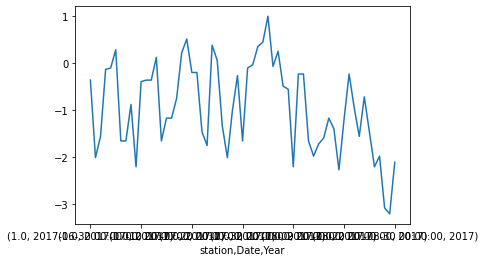

In [10]:
y_test_Tmax_st1.plot()

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler2 = MinMaxScaler()
data_fit = scaler2.fit(np.array(y_test_Tmax).reshape(-1, 1))
data_test = data_fit.transform(np.array(y_test_Tmax).reshape(-1, 1))

scaler3 = MinMaxScaler()
data_fit2 = scaler3.fit(np.array(y_train_Tmax).reshape(-1, 1))
data_test2 = data_fit.transform(np.array(y_train_Tmax).reshape(-1, 1))



In [16]:
X_train_2 = X_train.drop(['Present_Tmin', 
                          'DEM', 'LDAPS_CC1', 'LDAPS_RHmin', 'Solar radiation'], axis=1)
X_test_2 = X_test.drop(['Present_Tmin',
                     'DEM', 'LDAPS_CC1', 'LDAPS_RHmin','Solar radiation'], axis=1)


In [17]:
X_test_st1_2 = X_test_st1.drop(['Present_Tmin', 
                                'DEM', 'LDAPS_RHmin', 'Solar radiation'], axis=1)

X_train_st1_2 = X_train_st1.drop(['Present_Tmin',
                                  'DEM', 'LDAPS_RHmin', 'Solar radiation'], axis=1)



In [23]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(
    n_estimators=500, criterion='mse', random_state=0)
regressor.fit(X_train_2, data_test2)
yfit_Tmax_RF = regressor.predict(X_test_2)
print("R-squared:", r2_score(data_test, yfit_Tmax_RF))
#print("MSE:", mean_squared_error(y_test_Tmax, yfit_Tmax_RF))


R-squared: 0.6649382416068665


In [16]:
X_test_2.columns

Index([              'Present_Tmax',                'LDAPS_RHmax',
                 'LDAPS_Tmax_lapse',                   'LDAPS_WS',
                         'LDAPS_LH',                  'LDAPS_CC2',
                        'LDAPS_CC3',                  'LDAPS_CC4',
                       'LDAPS_PPT1',                 'LDAPS_PPT2',
                       'LDAPS_PPT3',                 'LDAPS_PPT4',
                              'lat',                        'lon',
                            'Slope',              'LDAPS_LH_sqrt',
           ('Present_Tmax', 'mean'),      ('Present_Tmax', 'var'),
       ('LDAPS_Tmax_lapse', 'mean'),  ('LDAPS_Tmax_lapse', 'var')],
      dtype='object')

In [35]:
selected_columns = ['Present_Tmax', 'LDAPS_Tmax_lapse', 'LDAPS_RHmax', ]
start_point = 0.61
for column in X_train_2.columns:
    if column not in selected_columns:
        new_selection = selected_columns.copy()
        new_selection.append(column)
        regressor = RandomForestRegressor(
            n_estimators=500, criterion='mse', random_state=0)
        regressor.fit(
            X_train_2[new_selection], y_train_Tmax)
        yfit_Tmax_RF = regressor.predict(
            X_test_2[new_selection])
        print("R-squared:", r2_score(y_test_Tmax, yfit_Tmax_RF))
        if start_point<r2_score(y_test_Tmax, yfit_Tmax_RF):
            start_point = r2_score(y_test_Tmax, yfit_Tmax_RF)
            selected_columns = new_selection


R-squared: 0.5834966551995133
R-squared: 0.600403178718281
R-squared: 0.6210819542991032
R-squared: 0.6487065173092037
R-squared: 0.650332668479514
R-squared: 0.6400354566922174
R-squared: 0.6490936990881294
R-squared: 0.6566602038898348
R-squared: 0.6528141476991023
R-squared: 0.64902957438377
R-squared: 0.6619921278008098
R-squared: 0.6718605322087525
R-squared: 0.6710785227860308
R-squared: 0.6718834016907065
R-squared: 0.6746471674331126
R-squared: 0.6763130724765715
R-squared: 0.6785552382993214
R-squared: 0.6800126211507134


In [36]:
selected_columns

['Present_Tmax',
 'LDAPS_Tmax_lapse',
 'LDAPS_RHmax',
 'LDAPS_LH',
 'LDAPS_CC2',
 'LDAPS_CC3',
 'LDAPS_PPT2',
 'lat',
 'lon',
 'LDAPS_LH_sqrt',
 ('Present_Tmax', 'mean'),
 ('Present_Tmax', 'var'),
 ('LDAPS_Tmax_lapse', 'mean'),
 ('LDAPS_Tmax_lapse', 'var')]

In [248]:
yfit_RF = regressor.predict(X_test_st1_2)
print("R-squared:", r2_score(y_test_Tmax_st1, yfit_RF))


ValueError: X has 21 features, but DecisionTreeRegressor is expecting 20 features as input.

In [208]:
y_test_Tmin_st1_frame = y_test_Tmax_st1.to_frame('Next_Tmax')
y_test_Tmin_st1_frame['Next_Tmax'] = y_scaler_fit_Tmax.inverse_transform(
    y_test_Tmax_st1)
forecast_results = pd.merge(
    X_test_2, y_test_Tmin_st1_frame, left_index=True, right_index=True)
forecast_results = forecast_results.reset_index()
forecast_results = forecast_results.merge(pd.DataFrame(y_scaler_fit_Tmax.inverse_transform(
    yfit_RF), columns=['Previsão']).reset_index(drop=True), left_index=True, right_index=True)
forecast_results.head()


,station,Date,Year,Present_Tmax,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC2,LDAPS_CC3,...,lat,lon,Slope,shifted,"(Present_Tmax, mean)","(Present_Tmax, var)","(LDAPS_Tmax_lapse, mean)","(LDAPS_Tmax_lapse, var)",Next_Tmax,Previsão
0,1.0000000000,2017-06-30,2017,-0.6353088184,1.3296752649,-0.9846526951,-0.3077624363,0.3774573300,-0.1663095034,0.4625545486,...,1.1906687093,-0.0008005538,1.1163202881,-2.0410391867,-3.9078472456,-2.3549821738,-3.3028016064,-1.1219081681,29.2000000000,27.6425000000
1,1.0000000000,2017-07-01,2017,-0.1975405447,1.6303044350,-1.8206951910,1.0452531562,-1.4810510643,2.0502368857,2.3963780539,...,1.1906687093,-0.0008005538,1.1163202881,-0.0313746958,-3.5636835801,-1.1388868603,-2.1716234467,-1.0268549045,24.1000000000,24.2900000000
2,1.0000000000,2017-07-02,2017,-2.0159626049,1.6313746261,-1.9865524721,1.6574241297,-1.4632041717,1.9106409142,1.6510270326,...,1.1906687093,-0.0008005538,1.1163202881,-0.2016852459,-3.5636835801,-1.1388868603,-2.1716234467,-1.0268549045,25.5000000000,24.3055000000
3,1.0000000000,2017-07-03,2017,-1.6118688137,1.1605716197,-0.1451819785,0.0932883947,1.7277960498,-0.8103767127,-0.5267167261,...,1.1906687093,-0.0008005538,1.1163202881,-2.0410391867,-3.5636835801,-1.1388868603,-2.1716234467,-1.0268549045,29.9000000000,28.9075000000
4,1.0000000000,2017-07-04,2017,-0.3995874402,0.0327526714,-0.0197111715,-0.3097391219,1.6526904482,-0.8573627480,-0.7628499555,...,1.1906687093,-0.0008005538,1.1163202881,-1.6322938665,-3.5636835801,-1.1388868603,-2.1716234467,-1.0268549045,30.0000000000,29.5560000000


In [209]:
import plotly.express as px
fig = px.line(forecast_results, x='Date', y=['Next_Tmax', 'Previsão'], labels={
              'value': "Temperatura Mínima Seoul (°C)"}, title='Previsão Modelo SVR (Temperatura Mínima T+1)', width=800, height=400)
fig.show()


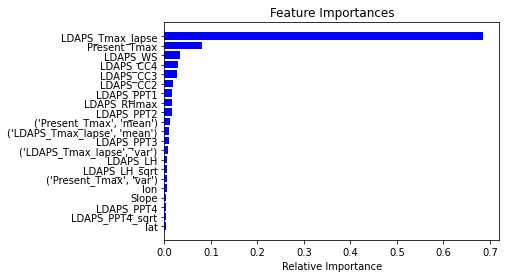

In [255]:
importances = regressor.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_train_2.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [40]:
from sklearn.svm import SVR
selected_columns = ['Present_Tmax', 'LDAPS_Tmax_lapse', 'LDAPS_RHmax', ]
start_point = 0.61
for column in X_train_2.columns:
 new_selection = selected_columns.copy()
 new_selection.append(column)
 model = SVR(C=14, epsilon=0.05, kernel='rbf')
 svr_Tmax = model.fit(X_train, y_train_Tmax.ravel())
 yfit = svr_Tmax.predict(X_test)
 score = svr_Tmax.score(X_test, y_test_Tmax)
 print(score)
 if score < start_point:
  start_point=score
  selected_columns  = new_selection


0.7083662304675455


KeyboardInterrupt: 

In [309]:
X_train


,,,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,LDAPS_CC2,...,lat,lon,DEM,Slope,Solar radiation,LDAPS_LH_sqrt,"(Present_Tmax, mean)","(Present_Tmax, var)","(LDAPS_Tmax_lapse, mean)","(LDAPS_Tmax_lapse, var)"
station,Date,Year,,,,,,,,,,,,,,,,,,,,,
1.0000000000,2013-06-30,2013,-0.3653383979,-0.7445584311,0.1293300837,0.4009136678,-0.5467686129,-0.2184673412,-0.1123668595,0.2063434497,-0.4967436561,-0.5721188359,...,1.1909791523,-0.0008937323,2.7719455184,1.1158026774,1.5178043416,-0.0430410631,-3.9073404991,-2.3551594179,-3.3030309878,-1.1224545424
2.0000000000,2013-06-30,2013,0.7123343429,-0.6615070705,-0.2838103209,0.3300405529,0.0627202401,0.2182221624,-0.6339702239,-0.3123700041,-0.5291548732,-0.3829696393,...,1.1909791523,0.5161022060,-0.3145293386,-0.5414767779,1.2299608150,-0.4573852997,-0.4937728746,-2.8086129777,-0.9909592118,-1.0918245038
3.0000000000,2013-06-30,2013,0.6113025234,0.0444294954,-0.5301463032,-0.5885093351,0.1452633014,0.4436127145,-0.4273954269,-1.2412727833,-0.5912351283,-0.3604574512,...,0.6543940111,0.8439532889,-0.5255269682,-0.7224646263,1.2165523258,-0.9006107579,-0.4937728746,-3.4419280054,-0.3791288896,-0.7929594966
4.0000000000,2013-06-30,2013,0.7460116160,0.0859551757,0.1282338772,1.1443997125,0.0126119540,-0.0828648831,-0.6533347045,0.0960321263,-0.5642425427,-0.4847787020,...,1.9938695118,0.3900056357,-0.2969652355,0.9332092917,1.2012013692,-0.1411667504,-0.0813955777,-2.9542754341,-1.5659658732,-1.2709044172
5.0000000000,2013-06-30,2013,0.5439479771,-0.5369300294,-0.0141859881,0.2677626346,-0.1900360119,-0.0147739303,-0.6140157770,1.3469842064,-0.8137425726,-0.3899867106,...,0.1197962222,1.8148968804,-0.4936404588,-0.5477529694,1.2072277962,1.2886347172,-0.0126660282,-3.5742908462,-1.5950780572,-1.5150961413
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21.0000000000,2016-08-30,2016,-1.9818475091,-1.4089693166,1.7826252269,0.2009953034,-3.0702932512,-2.8257121541,3.6318681262,0.7258568403,1.5204452602,2.0287472562,...,0.1197962222,0.6169794623,-0.6546201790,-0.4991489747,-2.1548774888,0.4917842114,0.5432901221,0.5946089813,1.6193604472,1.5984751185
22.0000000000,2016-08-30,2016,-1.8134611434,-1.4504949970,1.6062216278,0.2918710343,-2.9882542551,-2.7430136516,3.1393523041,0.9761527231,1.6283593735,2.1856685706,...,-0.6850814896,1.1970236858,-0.7343953922,-0.8194536789,-2.1883043188,0.7922683623,1.2611843890,1.0744789874,0.6856783133,0.9803265399
23.0000000000,2016-08-30,2016,-1.6787520508,-1.3674436363,1.7892345559,0.3717515076,-3.0405970823,-2.8006852672,3.4440339931,0.6721241605,1.5598943421,2.3749261151,...,-0.1484963484,-1.2618594355,-0.8518921692,-0.8032523473,-2.1846536610,0.4309070029,1.5599094070,1.0870783997,0.0940392489,0.2884502394


In [325]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ReduceLROnPlateau
n_input = len(X_train.columns)
model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(n_input,)))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.9, patience=5, min_lr=0.000001, verbose=1)
history = model.fit(X_train, y_train_Tmax, epochs=20, verbose=1,
                    callbacks=[reduce_lr], shuffle=True, validation_data=(X_test, y_test_Tmax))
yfit_Tmax_mlp = model.predict(X_test)


Epoch 1/20
186/186 [==============================] - 2s 3ms/step - loss: 0.9721 - val_loss: 0.6155
Epoch 2/20
186/186 [==============================] - 0s 2ms/step - loss: 0.6243 - val_loss: 0.4543
Epoch 3/20
186/186 [==============================] - 0s 1ms/step - loss: 0.4106 - val_loss: 0.4014
Epoch 4/20
186/186 [==============================] - 0s 2ms/step - loss: 0.3134 - val_loss: 0.3699
Epoch 5/20
186/186 [==============================] - 0s 2ms/step - loss: 0.2668 - val_loss: 0.3529
Epoch 6/20
186/186 [==============================] - 0s 2ms/step - loss: 0.2435 - val_loss: 0.3442
Epoch 7/20
186/186 [==============================] - 0s 2ms/step - loss: 0.2322 - val_loss: 0.3388
Epoch 8/20
186/186 [==============================] - 0s 2ms/step - loss: 0.2214 - val_loss: 0.3419
Epoch 9/20
186/186 [==============================] - 0s 2ms/step - loss: 0.2152 - val_loss: 0.3413
Epoch 10/20
186/186 [==============================] - 0s 2ms/step - loss: 0.1994 - val_loss: 0.3264

In [326]:
from sklearn.metrics import mean_squared_error
print("R-squared:",  r2_score(y_scaler_fit_Tmax.inverse_transform(y_test_Tmax),
      y_scaler_fit_Tmax.inverse_transform(yfit_Tmax_mlp)))
print("MSE:", mean_squared_error(y_scaler_fit_Tmax.inverse_transform(y_test_Tmax),
      y_scaler_fit_Tmax.inverse_transform(yfit_Tmax_mlp)))


R-squared: 0.6912686412961031
MSE: 3.0173749742768745


In [332]:
print("R-squared:", r2_score(y_test_Tmax, X_test.LDAPS_Tmax_lapse))


R-squared: 0.6299446540629576


In [36]:
pd.options.display.float_format = '{:,.10f}'.format
db = pd.read_csv('Bias_correction_ucl.csv').dropna()
db.Date = pd.to_datetime(db.Date)
db['Year'] = db.Date.dt.year
db['month'] = db.Date.dt.month

db['LDAPS_LH_sqrt'] = db.LDAPS_LH**2
# Daily Cloud cover
db_aux = db.groupby(['station', 'month']).agg({"Present_Tmax": [
    "mean", "var"], "LDAPS_Tmax_lapse": ["mean", "var"]}).reset_index()
db.Present_Tmax = db.Present_Tmax ** 2
db = db.merge(db_aux, on=['station', 'month'], how='left')
db = db.drop(['month'], axis=1)

db = db.set_index(['station', 'Date', 'Year'])
db = db[(np.abs(stats.zscore(db)) < 6).all(axis=1)]
#db['Test_feature'] =
#target = db[['Next_Tmax', 'Next_Tmin']]
#features = db.drop(['Next_Tmax', 'Next_Tmin'], axis=1)


In [50]:
np.array(db).reshape(-1, len(db.columns))[0]


array([8.23690000e+02, 2.14000000e+01, 5.82556877e+01, 9.11163635e+01,
       2.80741015e+01, 2.30069362e+01, 6.81888697e+00, 6.94518053e+01,
       2.33947471e-01, 2.03895710e-01, 1.61696854e-01, 1.30928198e-01,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.76046000e+01, 1.26991000e+02, 2.12335000e+02, 2.78500000e+00,
       5.99289600e+03, 2.91000000e+01, 2.12000000e+01, 4.82355326e+03,
       2.63400000e+01, 4.40300000e+00, 2.67360782e+01, 5.37164735e+00,
       0.00000000e+00])

In [51]:
from sklearn.cluster import KMeans
X = np.array(db).reshape(-1, len(db.columns))
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)
kmeans.labels_


array([1, 0, 0, ..., 1, 0, 0])

In [52]:
db['Cluster'] = kmeans.labels_


In [53]:
db[['Next_Tmax','Cluster']]


,,,Next_Tmax,Cluster
station,Date,Year,,
1.0000000000,2013-06-30,2013,29.1000000000,1
2.0000000000,2013-06-30,2013,30.5000000000,0
3.0000000000,2013-06-30,2013,31.1000000000,0
4.0000000000,2013-06-30,2013,31.7000000000,1
5.0000000000,2013-06-30,2013,31.2000000000,3
...,...,...,...,...
21.0000000000,2017-08-30,2017,27.6000000000,0
22.0000000000,2017-08-30,2017,28.0000000000,1
23.0000000000,2017-08-30,2017,28.3000000000,1


In [54]:
target = db[['Next_Tmax', 'Next_Tmin']]
features = db.drop(['Next_Tmax', 'Next_Tmin'], axis=1)
x_scaler = StandardScaler()
norm_features = pd.DataFrame(x_scaler.fit_transform(
    features.values), columns=features.columns, index=features.index)
y_scaler_Tmax = StandardScaler()
y_scaler_fit_Tmax = y_scaler_Tmax.fit(
    np.array(target['Next_Tmax']).reshape(-1, 1))
target_norm_max = pd.DataFrame(y_scaler_Tmax.fit_transform(np.array(
    target['Next_Tmax']).reshape(-1, 1)), columns=target[['Next_Tmax']].columns, index=target[['Next_Tmax']].index)
y_scaler_Tmin = StandardScaler()
y_scaler_fit_Tmin = y_scaler_Tmin.fit(
    np.array(target['Next_Tmin']).reshape(-1, 1))
target_norm_Tmin = pd.DataFrame(y_scaler_Tmin.fit_transform(np.array(
    target['Next_Tmin']).reshape(-1, 1)), columns=target[['Next_Tmin']].columns, index=target[['Next_Tmin']].index)
X_train = norm_features.loc[pd.IndexSlice[:, :, [2013, 2014, 2015, 2016]], :]
X_test = norm_features.loc[pd.IndexSlice[:, :, [2017]], :]
y_train_Tmax = target_norm_max.loc[pd.IndexSlice[:, :, [
    2013, 2014, 2015, 2016]], :]['Next_Tmax']
y_test_Tmax = target_norm_max.loc[pd.IndexSlice[:, :, [2017]], :]['Next_Tmax']
y_train_Tmin = target_norm_Tmin.loc[pd.IndexSlice[:, :, [
    2013, 2014, 2015, 2016]], :]['Next_Tmin']
y_test_Tmin = target_norm_Tmin.loc[pd.IndexSlice[:, :, [2017]], :]['Next_Tmin']


X_train_st1 = norm_features.loc[pd.IndexSlice[[
    1], :, [2013, 2014, 2015, 2016]], :]
X_test_st1 = norm_features.loc[pd.IndexSlice[[1], :, [2017]], :]
y_train_Tmax_st1 = target_norm_max.loc[pd.IndexSlice[[
    1], :, [2013, 2014, 2015, 2016]], :]['Next_Tmax']
y_test_Tmax_st1 = target_norm_max.loc[pd.IndexSlice[[
    1], :, [2017]], :]['Next_Tmax']
y_train_Tmin_st1 = target_norm_Tmin.loc[pd.IndexSlice[[
    1], :, [2013, 2014, 2015, 2016]], :]['Next_Tmin']
y_test_Tmin_st1 = target_norm_Tmin.loc[pd.IndexSlice[[
    1], :, [2017]], :]['Next_Tmin']


In [56]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ReduceLROnPlateau
n_input = len(X_train.columns)
model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(n_input,)))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, min_lr=0.000001, verbose=1)
history = model.fit(X_train, y_train_Tmax, epochs=200, verbose=1,
                    callbacks=[reduce_lr], shuffle=True, validation_data=(X_test, y_test_Tmax))
yfit_Tmax_mlp = model.predict(X_test)


Epoch 1/200
186/186 [==============================] - 2s 4ms/step - loss: 1.0087 - val_loss: 0.4284
Epoch 2/200
186/186 [==============================] - 0s 2ms/step - loss: 0.4275 - val_loss: 0.3866
Epoch 3/200
186/186 [==============================] - 0s 1ms/step - loss: 0.3086 - val_loss: 0.3660
Epoch 4/200
186/186 [==============================] - 0s 2ms/step - loss: 0.2617 - val_loss: 0.3510
Epoch 5/200
186/186 [==============================] - 0s 2ms/step - loss: 0.2420 - val_loss: 0.3450
Epoch 6/200
186/186 [==============================] - 0s 1ms/step - loss: 0.2428 - val_loss: 0.3354
Epoch 7/200
186/186 [==============================] - 0s 2ms/step - loss: 0.2193 - val_loss: 0.3336
Epoch 8/200
186/186 [==============================] - 0s 2ms/step - loss: 0.2065 - val_loss: 0.3321
Epoch 9/200
186/186 [==============================] - 0s 2ms/step - loss: 0.2017 - val_loss: 0.3362
Epoch 10/200
186/186 [==============================] - 0s 1ms/step - loss: 0.1951 - val_lo

In [57]:
from sklearn.metrics import mean_squared_error
print("R-squared:",  r2_score(y_scaler_fit_Tmax.inverse_transform(y_test_Tmax),
      y_scaler_fit_Tmax.inverse_transform(yfit_Tmax_mlp)))
print("MSE:", mean_squared_error(y_scaler_fit_Tmax.inverse_transform(y_test_Tmax),
      y_scaler_fit_Tmax.inverse_transform(yfit_Tmax_mlp)))


R-squared: 0.6839303097218357
MSE: 3.0890958974059606
